In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import date
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns 
import warnings
import os
import boto3
import re
import sagemaker
sns.set()

## Data descriptions
File descriptions

train.csv - the training set (contains 1458644 trip records)

test.csv - the testing set (contains 625134 trip records)

id - a unique identifier for each trip

vendor_id - a code indicating the provider associated with the trip record

pickup_datetime - date and time when the meter was engaged

dropoff_datetime - date and time when the meter was disengaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

trip_duration - duration of the trip in seconds

## Explore the data and feature selection

In [ ]:
data = pd.read_csv("train.csv",parse_dates = ["pickup_datetime"])
dates = ['pickup_datetime']
test = pd.read_csv("test.csv",parse_dates = ['pickup_datetime'])

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  625134 non-null  object        
 1   vendor_id           625134 non-null  int64         
 2   pickup_datetime     625134 non-null  datetime64[ns]
 3   passenger_count     625134 non-null  int64         
 4   pickup_longitude    625134 non-null  float64       
 5   pickup_latitude     625134 non-null  float64       
 6   dropoff_longitude   625134 non-null  float64       
 7   dropoff_latitude    625134 non-null  float64       
 8   store_and_fwd_flag  625134 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


In [ ]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
# sepreate the datetime
for df in (data,test):
    df['pick_year'] = df['pickup_datetime'].dt.year
    df['pick_month'] = df['pickup_datetime'].dt.month
    df['pick_day'] = df['pickup_datetime'].dt.day
    df['pick_hr'] = df['pickup_datetime'].dt.hour
    df['pick_minute'] = df['pickup_datetime'].dt.minute
    df['pick_weekday']=df['pickup_datetime'].dt.weekday
#converting flag into 0 or 1
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values== 'Y')

In [ ]:
data['isweekend']= data.apply(lambda x : (x['pick_weekday']==6 | x['pick_weekday']==5),axis=1)
data['isweekend']=data['isweekend'].map({True: 1, False:0})
test['isweekend']= test.apply(lambda x : (x['pick_weekday']==6 | x['pick_weekday']==5),axis=1)
test['isweekend']=test['isweekend'].map({True: 1, False:0})

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_year,pick_month,pick_day,pick_hr,pick_minute,pick_weekday,isweekend
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016,3,14,17,24,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016,6,12,0,43,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016,1,19,11,35,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2016,4,6,19,32,2,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,2016,3,26,13,30,5,0


In [ ]:
me = np.mean(data['trip_duration'])
st = np.std(data['trip_duration'])
data = data[data['trip_duration'] <= me + 2*st]
data = data[data['trip_duration'] >= me - 2*st]

In [ ]:
#create a log column for trip duration 
data = data.assign(log_trip_duration = np.log(data.trip_duration+1)) 

In [ ]:
data= data[data['pickup_longitude'] <= -73.75]
data= data[data['pickup_longitude'] >= -74.03]
data= data[data['pickup_latitude'] <= 40.85]
data= data[data['pickup_latitude'] >= 40.63]
data= data[data['dropoff_longitude'] <= -73.75]
data= data[data['dropoff_longitude'] >= -74.03]
data= data[data['dropoff_latitude'] <= 40.85]
data= data[data['dropoff_latitude'] >= 40.63]

In [ ]:
coord_pickup = np.vstack((data[['pickup_latitude', 'pickup_longitude']].values, test[['pickup_latitude','pickup_longitude']].values))
coord_dropoff = np.vstack((data[['dropoff_latitude', 'dropoff_longitude']].values, test[['dropoff_latitude','dropoff_longitude']].values))

In [ ]:
coords = np.hstack((coord_pickup,coord_dropoff))

In [ ]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size =10000).fit(coords[sample_ind])
for df in (data,test):
    df.loc[:,'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude',
                                                         'dropoff_latitude','dropoff_longitude']])

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(


In [ ]:
kmean_data = data[['pickup_dropoff_loc']]
kmean_test = test[['pickup_dropoff_loc']]

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_year,pick_month,pick_day,pick_hr,pick_minute,log_trip_duration,pickup_dropoff_loc
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016,3,14,17,24,6.122493,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016,6,12,0,43,6.498282,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016,1,19,11,35,7.661527,6
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2016,4,6,19,32,6.063785,6
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,2016,3,26,13,30,6.077642,1


In [ ]:
## NYC holiday data 
holiday = pd.read_csv("NYC_2016Holidays.csv",sep=";")

In [ ]:

holidays = [datetime]
time_data = pd.DataFrame(index = range(len(data)))  
time_test = pd.DataFrame(index = range(len(test)))

In [ ]:
def find_holiday(yr, month, day, holidays):
    holiday =  [None]*len(yr)
    weekend =  [None]*len(yr)
    i = 0 
    for yy,mm,dd in zip(yr, month, day):
        #checking for saturday sunday(6,7), date.isoweekday() returns the day
        weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        holiday[i] = weekend[i] or date(yy,mm,dd)  in holidays
        i+=1
    return holiday, weekend

In [ ]:
#for training data, creating rest_day and weekend columns in a new dataframe (will merge later)
rest_day,weekend = find_holiday(data.pick_year, data.pick_month, data.pick_day, holidays)
time_data = time_data.assign(rest_day = rest_day)
time_data = time_data.assign(weekend = weekend)

#replicating for test data
rest_day,weekend = find_holiday(test.pick_year, test.pick_month, test.pick_day, holidays)
time_test = time_test.assign(rest_day = rest_day)
time_test = time_test.assign(weekend = weekend)

In [ ]:
#changing time into floats 
time_data = time_data.assign(pickup_time = data.pick_hr+data.pick_minute/60)
time_test = time_test.assign(pickup_time = test.pick_hr+ test.pick_minute/60)

In [ ]:
holiday.head()

,Day,Date,Holiday
0,Friday,January 01,New Years Day
1,Monday,January 18,Martin Luther King Jr. Day
2,Friday,February 12,Lincoln's Birthday
3,Monday,February 15,Presidents' Day
4,Sunday,May 08,Mother's Day


In [ ]:
weather = pd.read_csv("KNYC_Metars.csv",parse_dates=['Time'])

In [ ]:
weather.head(5)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast


In [ ]:
weather['snow'] = 1*(weather.Events == 'Snow') + 1*(weather.Events == 'Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hr'] = weather['Time'].dt.hour
weather = weather[weather['year']== 2016][['month','day','hr','Temp.','Precip','snow', 'Visibility']]

In [ ]:
weather = weather.rename(columns={'month':'pick_month',
                                  'day':'pick_day',
                                  'hr':'pick_hr'})

In [ ]:
weather.head(5)

,pick_month,pick_day,pick_hr,Temp.,Precip,snow,Visibility
22,1,1,0,5.6,0.0,0,16.1
23,1,1,1,5.6,0.0,0,16.1
24,1,1,2,5.6,0.0,0,16.1
25,1,1,3,5.0,0.0,0,16.1
26,1,1,4,5.0,0.0,0,16.1


In [ ]:
data = pd.merge(data, weather, on=['pick_month', 'pick_day', 'pick_hr'], how = 'left')
test = pd.merge(test, weather, on=['pick_month', 'pick_day', 'pick_hr'], how = 'left')

In [ ]:
weather_data = data[['Temp.','Precip','snow','Visibility']]
weather_test = test[['Temp.','Precip','snow','Visibility']]

In [ ]:
weather_data.head()

,Temp.,Precip,snow,Visibility
0,4.4,0.3,0.0,8.0
1,28.9,0.0,0.0,16.1
2,-6.7,0.0,0.0,16.1
3,7.2,0.0,0.0,16.1
4,9.4,0.0,0.0,16.1


In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1,lng1,lat2,lng2 = map(np.radians, (lat1,lng1,lat2,lng2))
    earth_radius = 6371 #km
    lat = lat2-lat1
    lng = lng2-lng1
    d = np.sin(lat*0.5) **2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng *0.5)**2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lat2, lng1, lng2):
    a = haversine_array(lat1,lng1,lat1,lng2)
    b = haversine_array(lat1,lng1,lat2,lng1)
    return a+b

def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


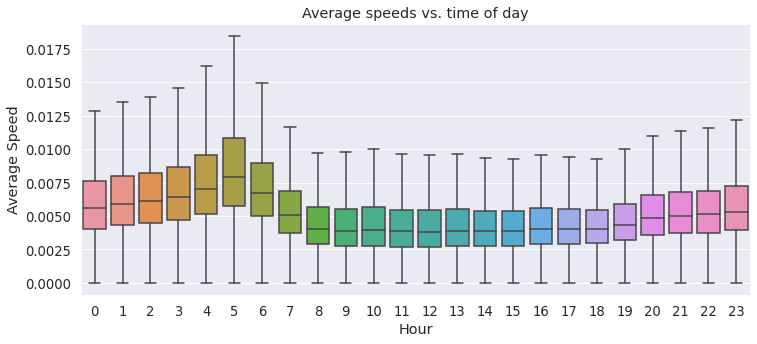

In [ ]:
# Calculate the manhattan distance and speed
manhattan = manhattan_distance(data['pickup_latitude'],data['dropoff_latitude'],data['pickup_longitude'],data['dropoff_longitude'])
manhattan_speed = manhattan / data['trip_duration']

# Plot speed against the time of day
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
sns.boxplot(data['pick_hr'], manhattan_speed, showfliers=False)
plt.title('Average speeds vs. time of day')
plt.ylabel('Average Speed')
plt.xlabel('Hour')
plt.show()


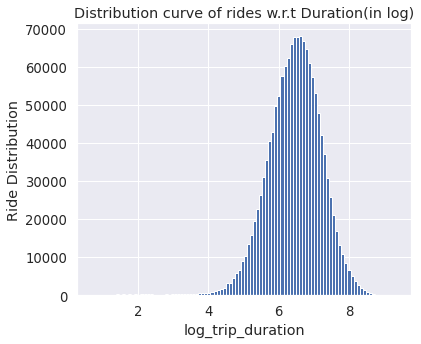

In [ ]:
# distributionof trip duration
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.hist(sorted(data['log_trip_duration']), bins=100)
plt.title('Distribution curve of rides w.r.t Duration(in log)')
plt.ylabel('Ride Distribution')
plt.xlabel('log_trip_duration')
plt.show()

In [ ]:
tempdata = data
tempdata = pd.concat([tempdata, time_data], axis=1)

Text(0.5, 1.0, 'log_trip_duration vs hr of the day')

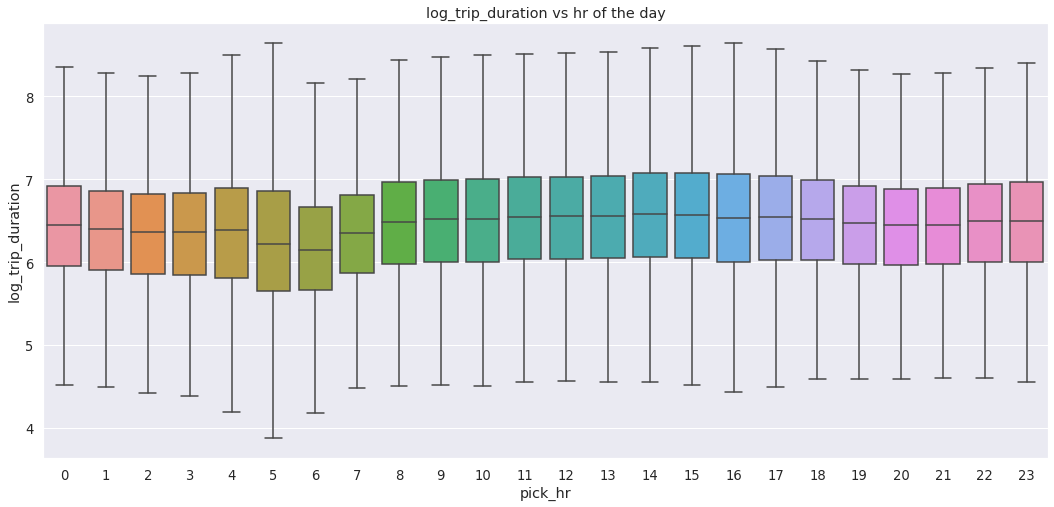

In [ ]:
sns.set(font_scale=1.2)
plt.figure(figsize=(18, 8))
sns.boxplot(x = "pick_hr", y="log_trip_duration", data = data, showfliers = False)
plt.title("log_trip_duration vs hr of the day")

Text(0.5, 1.0, 'Comparision of log_trip_duration vs month for rest_day and working day')

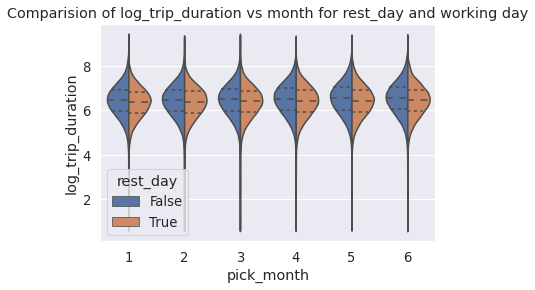

In [ ]:
#month vs trip_duration
sns.violinplot(x = "pick_month", y="log_trip_duration", hue = "rest_day", data=tempdata, split=True, inner = "quart")
plt.title("Comparision of log_trip_duration vs month for rest_day and working day")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437128 entries, 0 to 1437127
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1437128 non-null  object        
 1   vendor_id           1437128 non-null  int64         
 2   pickup_datetime     1437128 non-null  datetime64[ns]
 3   dropoff_datetime    1437128 non-null  object        
 4   passenger_count     1437128 non-null  int64         
 5   pickup_longitude    1437128 non-null  float64       
 6   pickup_latitude     1437128 non-null  float64       
 7   dropoff_longitude   1437128 non-null  float64       
 8   dropoff_latitude    1437128 non-null  float64       
 9   store_and_fwd_flag  1437128 non-null  int64         
 10  trip_duration       1437128 non-null  int64         
 11  pick_year           1437128 non-null  int64         
 12  pick_month          1437128 non-null  int64         
 13  pick_day    